In [48]:
import pandas as pd
import numpy as np
import pickle
import joblib
import torch
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, precision_score, recall_score

In [4]:
#df = pd.read_csv('human_seq.csv')
with open('human_seq_manual_feat_dict.pkl', 'rb') as f:
  data = joblib.load(f)


In [5]:
n = 0
for k in data[10785]['seq_manual_feat_dict'].keys():
  n  += len(data[10785]['seq_manual_feat_dict'][k])

print('Num of Features: ', n)

Num of Features:  1218


In [6]:
class NeuralNet(torch.nn.Module):

  def __init__(self):
    super().__init__()
    self.dropout = torch.nn.Dropout(p=0.2)
    self.relu = torch.nn.ReLU()

    self.l1 = torch.nn.Linear(2436, 1024)
    self.bn1 = torch.nn.BatchNorm1d(1024)

    self.l2 = torch.nn.Linear(1024, 512)
    self.bn2 = torch.nn.BatchNorm1d(512)

    self.l3 = torch.nn.Linear(512, 512)
    self.bn3 = torch.nn.BatchNorm1d(512)

    self.l4 = torch.nn.Linear(512, 64)
    self.bn4 = torch.nn.BatchNorm1d(64)

    self.output = torch.nn.Linear(64, 1)
    self.sig = torch.nn.Sigmoid()
  def forward(self, x):

    h = self.l1(x)
    h = self.bn1(h)
    h = self.relu(h)
    h = self.dropout(h)

    h = self.l2(h)
    h = self.bn2(h)
    h = self.relu(h)
    h = self.dropout(h)

    h = self.l3(h)
    h = self.bn3(h)
    h = self.relu(h)
    h = self.dropout(h)

    h = self.l4(h)
    h = self.bn4(h)
    h = self.relu(h)
    h = self.dropout(h)

    y_pred = self.sig(self.output(h))

    return y_pred

In [7]:
def ret1dFeat(p1, p2):
  p1feat = []
  p2feat = []
  for k in data[p1]['seq_manual_feat_dict'].keys():
    p1feat += data[p1]['seq_manual_feat_dict'][k]
    p2feat += data[p2]['seq_manual_feat_dict'][k]

  return np.array(p1feat + p2feat)

In [8]:
class CustDataset(torch.utils.data.Dataset):

  def __init__(self, trainset, targetset):

    self.X = trainset
    self.y = targetset

  def __len__(self):
    return len(self.X)

  def __getitem__(self, idx):
    return [torch.tensor(self.X[idx]), torch.tensor(self.y[idx])]

Random 50

In [9]:
Trainset = []
Targetset = []

df = pd.read_csv(f'Random50_Train_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Trainset.append(feat)
  Targetset.append(target)


In [10]:
dataset_train = CustDataset(Trainset, Targetset)

TrainLoader = torch.utils.data.DataLoader(dataset_train, batch_size = 1024)

In [11]:
if torch.cuda.is_available():
    device  =  torch.device('cuda')
else:
    device = torch.device('cpu')

In [13]:
lr = 1e-3
n_epochs = 30
model = NeuralNet().to(device)
criterion = torch.nn.BCELoss()
TrainLoss = []
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(n_epochs):
  cur = 0
  for inp, target in TrainLoader:
    b, l = inp.shape
    inp = inp.to(device)
    target = target.to(device)
    y_pred = model(inp.float())
    loss = criterion(y_pred, target.reshape(b, 1).float())
    optimizer.zero_grad()
    loss.backward()
    cur += loss.item()
    optimizer.step()
  TrainLoss.append(cur)
  print(f"Epoch {epoch} : Loss :{cur}")




Epoch 0 : Loss :54.68838492035866
Epoch 1 : Loss :44.707598984241486
Epoch 2 : Loss :37.95172366499901
Epoch 3 : Loss :32.72528935968876
Epoch 4 : Loss :28.981670826673508
Epoch 5 : Loss :24.963388353586197
Epoch 6 : Loss :22.45319575071335
Epoch 7 : Loss :20.00520470738411
Epoch 8 : Loss :18.342746391892433
Epoch 9 : Loss :16.26178991049528
Epoch 10 : Loss :15.266057468950748
Epoch 11 : Loss :13.498684272170067
Epoch 12 : Loss :11.946781493723392
Epoch 13 : Loss :10.931184444576502
Epoch 14 : Loss :9.759884618222713
Epoch 15 : Loss :8.76652081683278
Epoch 16 : Loss :7.996077697724104
Epoch 17 : Loss :7.1509843692183495
Epoch 18 : Loss :6.693329222500324
Epoch 19 : Loss :6.015951801091433
Epoch 20 : Loss :5.911332409828901
Epoch 21 : Loss :5.242197718471289
Epoch 22 : Loss :5.1935873329639435
Epoch 23 : Loss :4.748227659612894
Epoch 24 : Loss :4.318344743922353
Epoch 25 : Loss :3.906073112040758
Epoch 26 : Loss :4.065614782273769
Epoch 27 : Loss :3.8696530535817146
Epoch 28 : Loss :3.4

Text(0.5, 1.0, 'Training Loss Vs Epoch')

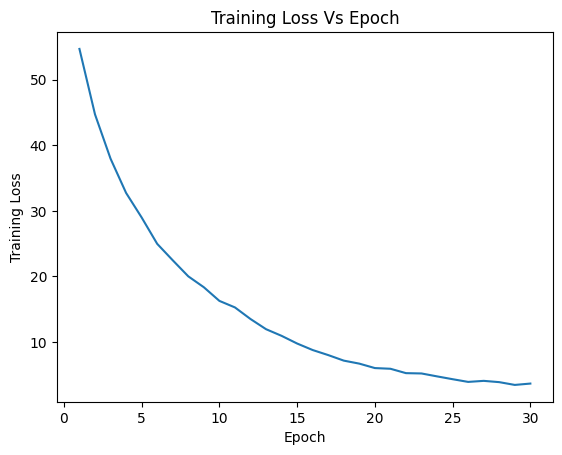

In [14]:
plt.plot(range(1, n_epochs + 1), TrainLoss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Vs Epoch')

In [16]:
Testset = []
Targetset = []

df = pd.read_csv(f'Random50_Test_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Testset.append(feat)
  Targetset.append(target)

dataset_test = CustDataset(Testset, Targetset)

TestLoader = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test))

In [19]:
correct = 0
tot = 0

with torch.no_grad():
  for inp, targetR50 in TestLoader:
    b, l = inp.shape
    inp = inp.to(device).float()
    targetR50 = targetR50.to(device).reshape(-1, 1)
    y_predR50 = model(inp)
    tot += len(y_predR50)
    correct += ((y_predR50 > 0.5).float() == targetR50).float().sum()


AccR50 = round(100 * correct.item() / tot, 2)
AUCR50 = roc_auc_score(targetR50.cpu().detach().numpy(), y_predR50.cpu().detach().numpy())
print(f'Accuracy:  {AccR50} %')
print(f'AUC Score: {AUCR50}')

Accuracy:  80.81 %
AUC Score: 0.8845026120358516


In [49]:
PreR50 = precision_score(targetR50.cpu().detach().numpy(), (y_predR50 > 0.5).float().cpu().detach().numpy())
RecR50 = recall_score(targetR50.cpu().detach().numpy(), (y_predR50 > 0.5).float().cpu().detach().numpy())
print(f'Precision :', PreR50)
print(f'Recall : ', RecR50)

Precision : 0.8155737704918032
Recall :  0.7962548015364916


Random 20

In [20]:
Trainset = []
Targetset = []

df = pd.read_csv(f'Random20_Train_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Trainset.append(feat)
  Targetset.append(target)


In [21]:
dataset_train = CustDataset(Trainset, Targetset)

TrainLoader = torch.utils.data.DataLoader(dataset_train, batch_size = 1024)

In [22]:
lr = 1e-3
n_epochs = 30
model = NeuralNet().to(device)
criterion = torch.nn.BCELoss()
TrainLoss = []
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(n_epochs):
  cur = 0
  for inp, target in TrainLoader:
    b, l = inp.shape
    inp = inp.to(device)
    target = target.to(device)
    y_pred = model(inp.float())
    loss = criterion(y_pred, target.reshape(b, 1).float())
    optimizer.zero_grad()
    loss.backward()
    cur += loss.item()
    optimizer.step()
  TrainLoss.append(cur)
  print(f"Epoch {epoch} : Loss :{cur}")

Epoch 0 : Loss :45.84238597750664
Epoch 1 : Loss :34.87108311057091
Epoch 2 : Loss :29.716278195381165
Epoch 3 : Loss :25.392644837498665
Epoch 4 : Loss :21.73807044327259
Epoch 5 : Loss :19.22205151617527
Epoch 6 : Loss :17.710219338536263
Epoch 7 : Loss :15.64079312980175
Epoch 8 : Loss :13.340113252401352
Epoch 9 : Loss :11.77397371828556
Epoch 10 : Loss :10.27121526747942
Epoch 11 : Loss :9.332372430711985
Epoch 12 : Loss :8.133258823305368
Epoch 13 : Loss :7.860275626182556
Epoch 14 : Loss :6.914961963891983
Epoch 15 : Loss :6.334430363029242
Epoch 16 : Loss :5.836860246956348
Epoch 17 : Loss :5.387344837188721
Epoch 18 : Loss :4.579437788575888
Epoch 19 : Loss :4.5891928263008595
Epoch 20 : Loss :4.002728687599301
Epoch 21 : Loss :3.7276213876903057
Epoch 22 : Loss :3.4362032022327185
Epoch 23 : Loss :3.3757097646594048
Epoch 24 : Loss :3.010342890396714
Epoch 25 : Loss :2.919509538449347
Epoch 26 : Loss :2.6629734514281154
Epoch 27 : Loss :2.7931153951212764
Epoch 28 : Loss :2.6

Text(0.5, 1.0, 'Training Loss Vs Epoch')

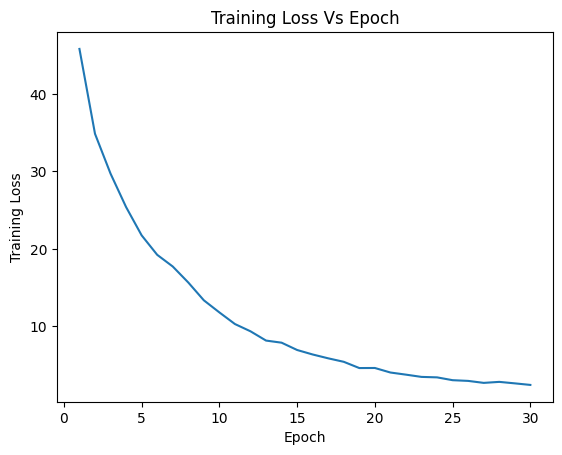

In [23]:
plt.plot(range(1, n_epochs + 1), TrainLoss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Vs Epoch')

In [24]:
Testset = []
Targetset = []

df = pd.read_csv(f'Random20_Test1_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Testset.append(feat)
  Targetset.append(target)

dataset_test = CustDataset(Testset, Targetset)

TestLoader = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test))

In [29]:
correct = 0
tot = 0

with torch.no_grad():
  for inp, targetR20 in TestLoader:
    b, l = inp.shape
    inp = inp.to(device).float()
    targetR20 = targetR20.to(device).reshape(-1, 1)
    y_predR20 = model(inp)
    tot += len(y_predR20)
    correct += ((y_predR20 > 0.5).float() == targetR20).float().sum()


AccR20 = round(100 * correct.item() / tot, 2)
AUCR20 = roc_auc_score(targetR20.cpu().detach().numpy(), y_predR20.cpu().detach().numpy())
PreR20 = precision_score(targetR20.cpu().detach().numpy(), (y_predR20 > 0.5).float().cpu().detach().numpy())

print(f'Accuracy:  {AccR20} %')
print(f'AUC Score: {AUCR20}')
print(f'Precision :', PreR20)

Accuracy:  86.53 %
AUC Score: 0.864518743230036
Precision : 0.3966593354336325


In [50]:
RecR20 = recall_score(targetR20.cpu().detach().numpy(), (y_predR20 > 0.5).float().cpu().detach().numpy())

print('Recall: ' ,RecR20)

Recall:  0.6676338169084542


HeldOut 50

In [33]:
Trainset = []
Targetset = []

df = pd.read_csv(f'HeldOut50_Train_0_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Trainset.append(feat)
  Targetset.append(target)


In [34]:
dataset_train = CustDataset(Trainset, Targetset)

TrainLoader = torch.utils.data.DataLoader(dataset_train, batch_size = 1024)

In [35]:
lr = 1e-3
n_epochs = 30
model = NeuralNet().to(device)
criterion = torch.nn.BCELoss()
TrainLoss = []
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(n_epochs):
  cur = 0
  for inp, target in TrainLoader:
    b, l = inp.shape
    inp = inp.to(device)
    target = target.to(device)
    y_pred = model(inp.float())
    loss = criterion(y_pred, target.reshape(b, 1).float())
    optimizer.zero_grad()
    loss.backward()
    cur += loss.item()
    optimizer.step()
  TrainLoss.append(cur)
  print(f"Epoch {epoch} : Loss :{cur}")

Epoch 0 : Loss :53.79869854450226
Epoch 1 : Loss :43.19516605138779
Epoch 2 : Loss :36.53947800397873
Epoch 3 : Loss :31.250512793660164
Epoch 4 : Loss :27.370483443140984
Epoch 5 : Loss :24.64840768277645
Epoch 6 : Loss :22.37177973985672
Epoch 7 : Loss :20.007413052022457
Epoch 8 : Loss :17.283532805740833
Epoch 9 : Loss :15.325734250247478
Epoch 10 : Loss :13.724896751344204
Epoch 11 : Loss :12.952772699296474
Epoch 12 : Loss :12.313343968242407
Epoch 13 : Loss :11.168981928378344
Epoch 14 : Loss :10.020172201097012
Epoch 15 : Loss :8.977982312440872
Epoch 16 : Loss :7.866180945187807
Epoch 17 : Loss :7.281222485005856
Epoch 18 : Loss :6.560278125107288
Epoch 19 : Loss :5.949957143515348
Epoch 20 : Loss :5.541339501738548
Epoch 21 : Loss :5.241722911596298
Epoch 22 : Loss :4.653573961928487
Epoch 23 : Loss :4.611894056200981
Epoch 24 : Loss :4.553922286257148
Epoch 25 : Loss :3.969472633674741
Epoch 26 : Loss :3.982247220352292
Epoch 27 : Loss :3.7293541664257646
Epoch 28 : Loss :3.

Text(0.5, 1.0, 'Training Loss Vs Epoch')

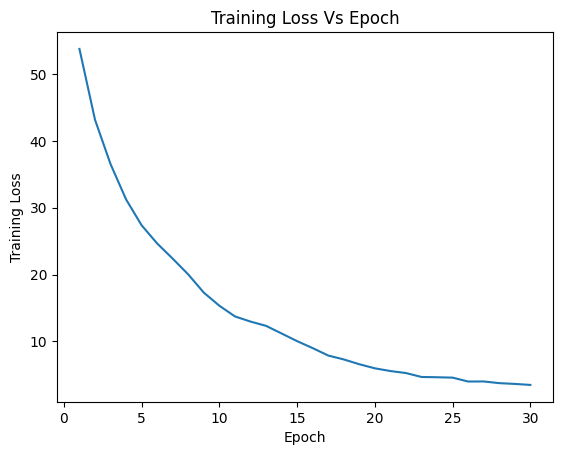

In [36]:
plt.plot(range(1, n_epochs + 1), TrainLoss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Vs Epoch')

In [37]:
Testset = []
Targetset = []

df = pd.read_csv(f'HeldOut50_Test_0_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Testset.append(feat)
  Targetset.append(target)

dataset_test = CustDataset(Testset, Targetset)

TestLoader = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test))

In [39]:
correct = 0
tot = 0

with torch.no_grad():
  for inp, targetH50 in TestLoader:
    b, l = inp.shape
    inp = inp.to(device).float()
    targetH50 = targetH50.to(device).reshape(-1, 1)
    y_predH50 = model(inp)
    tot += len(y_predH50)
    correct += ((y_predH50 > 0.5).float() == targetH50).float().sum()


AccH50 = round(100 * correct.item() / tot, 2)
AUCH50 = roc_auc_score(targetH50.cpu().detach().numpy(), y_predH50.cpu().detach().numpy())
PreH50 = precision_score(targetH50.cpu().detach().numpy(), (y_predH50 > 0.5).float().cpu().detach().numpy())

print(f'Accuracy:  {AccH50} %')
print(f'AUC Score: {AUCH50}')
print(f'Precision :', PreH50)

Accuracy:  65.97 %
AUC Score: 0.7168848997511196
Precision : 0.6558126249642959


In [52]:
RecH50 = recall_score(targetH50.cpu().detach().numpy(), (y_predH50 > 0.5).float().cpu().detach().numpy())

print('Recall: ',RecH50)

Recall:  0.6723279648609077


HeldOut 20

In [40]:
Trainset = []
Targetset = []

df = pd.read_csv(f'HeldOut20_Train_0_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Trainset.append(feat)
  Targetset.append(target)


In [41]:
dataset_train = CustDataset(Trainset, Targetset)

TrainLoader = torch.utils.data.DataLoader(dataset_train, batch_size = 1024)

In [42]:
lr = 1e-3
n_epochs = 30
model = NeuralNet().to(device)
criterion = torch.nn.BCELoss()
TrainLoss = []
optimizer = torch.optim.Adam(model.parameters(), lr = lr)

for epoch in range(n_epochs):
  cur = 0
  for inp, target in TrainLoader:
    b, l = inp.shape
    inp = inp.to(device)
    target = target.to(device)
    y_pred = model(inp.float())
    loss = criterion(y_pred, target.reshape(b, 1).float())
    optimizer.zero_grad()
    loss.backward()
    cur += loss.item()
    optimizer.step()
  TrainLoss.append(cur)
  print(f"Epoch {epoch} : Loss :{cur}")

Epoch 0 : Loss :50.09896272420883
Epoch 1 : Loss :35.51962798833847
Epoch 2 : Loss :30.161444783210754
Epoch 3 : Loss :25.72930681705475
Epoch 4 : Loss :22.17910870909691
Epoch 5 : Loss :19.38991618156433
Epoch 6 : Loss :17.581504814326763
Epoch 7 : Loss :15.812859065830708
Epoch 8 : Loss :13.789314679801464
Epoch 9 : Loss :12.129962474107742
Epoch 10 : Loss :10.921644568443298
Epoch 11 : Loss :10.126243203878403
Epoch 12 : Loss :9.456204406917095
Epoch 13 : Loss :8.082943730056286
Epoch 14 : Loss :6.748281501233578
Epoch 15 : Loss :5.611019529402256
Epoch 16 : Loss :5.480467211455107
Epoch 17 : Loss :4.946589294821024
Epoch 18 : Loss :4.726648949086666
Epoch 19 : Loss :4.405144983902574
Epoch 20 : Loss :3.8926629573106766
Epoch 21 : Loss :3.7921724393963814
Epoch 22 : Loss :3.302434764802456
Epoch 23 : Loss :3.338827235624194
Epoch 24 : Loss :3.3752306532114744
Epoch 25 : Loss :3.224810514599085
Epoch 26 : Loss :2.8808749467134476
Epoch 27 : Loss :2.6499107209965587
Epoch 28 : Loss :2

Text(0.5, 1.0, 'Training Loss Vs Epoch')

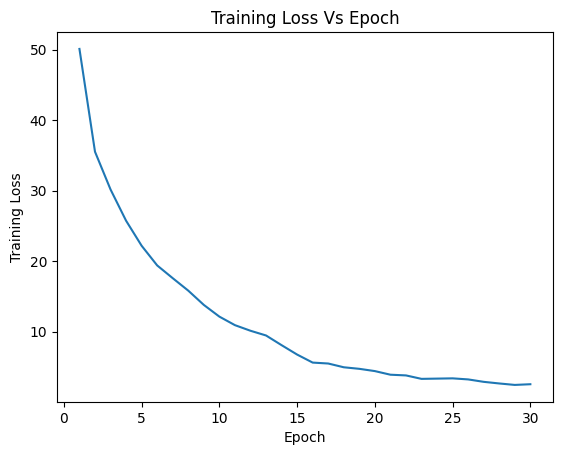

In [43]:
plt.plot(range(1, n_epochs + 1), TrainLoss)
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.title('Training Loss Vs Epoch')

In [44]:
Testset = []
Targetset = []

df = pd.read_csv(f'HeldOut20_Test1_0_0.tsv', sep='\t', header=None)
for i, r in df.iterrows():


  p1 = r[0]
  p2 = r[1]
  if p1 == 7273 or p2 == 7273:
    continue
  target = r[2]
  feat = ret1dFeat(p1, p2)
  Testset.append(feat)
  Targetset.append(target)

dataset_test = CustDataset(Testset, Targetset)

TestLoader = torch.utils.data.DataLoader(dataset_test, batch_size = len(dataset_test))

In [46]:
correct = 0
tot = 0

with torch.no_grad():
  for inp, targetH20 in TestLoader:
    b, l = inp.shape
    inp = inp.to(device).float()
    targetH20 = targetH20.to(device).reshape(-1, 1)
    y_predH20 = model(inp)
    tot += len(y_predH20)
    correct += ((y_predH20 > 0.5).float() == targetH20).float().sum()


AccH20 = round(100 * correct.item() / tot, 2)
AUCH20 = roc_auc_score(targetH20.cpu().detach().numpy(), y_predH20.cpu().detach().numpy())
PreH20 = precision_score(targetH20.cpu().detach().numpy(), (y_predH20 > 0.5).float().cpu().detach().numpy())

print(f'Accuracy:  {AccH20} %')
print(f'AUC Score: {AUCH20}')
print(f'Precision :', PreH20)

Accuracy:  81.22 %
AUC Score: 0.6949836425820212
Precision : 0.2382116660845267


In [53]:
RecH20 = recall_score(targetH20.cpu().detach().numpy(), (y_predH20 > 0.5).float().cpu().detach().numpy())

print(f'Recall: {RecH20}')

Recall: 0.3994143484626647


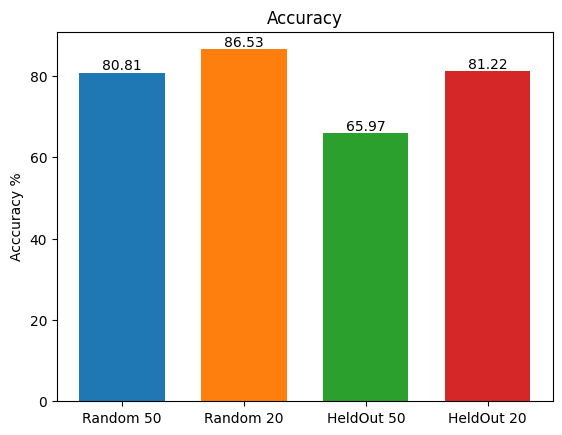

In [67]:
data_cat = ['Random 50', 'Random 20' ,'HeldOut 50', 'HeldOut 20']
y = [AccR50, AccR20, AccH50, AccH20]
fig, ax = plt.subplots()
x = np.arange(len(data_cat))
width = 0.7  # the width of the bars
for i, j in enumerate(y):
    rects = ax.bar(x[i], j, width, label=data_cat[i])
    ax.bar_label(rects, padding=0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, data_cat)
ax.set_ylabel('Acccuracy %')
ax.set_title('Accuracy')
plt.show()

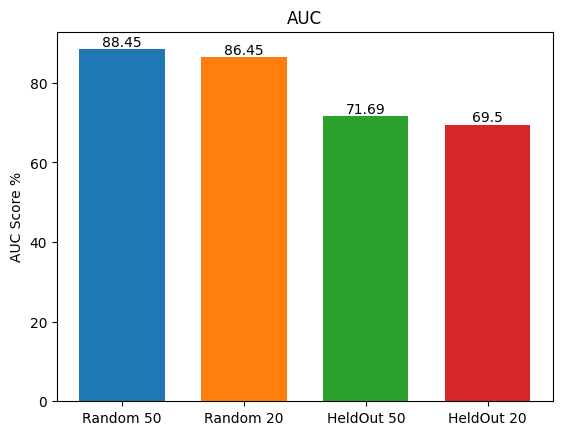

In [68]:
data_cat = ['Random 50', 'Random 20' ,'HeldOut 50', 'HeldOut 20']
y = [AUCR50, AUCR20, AUCH50, AUCH20]
y = [round(100 * x, 2) for x in y]
fig, ax = plt.subplots()
x = np.arange(len(data_cat))
width = 0.7  # the width of the bars
for i, j in enumerate(y):
    rects = ax.bar(x[i], j, width, label=data_cat[i])
    ax.bar_label(rects, padding=0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, data_cat)
ax.set_ylabel('AUC Score %')
ax.set_title('AUC')
plt.show()

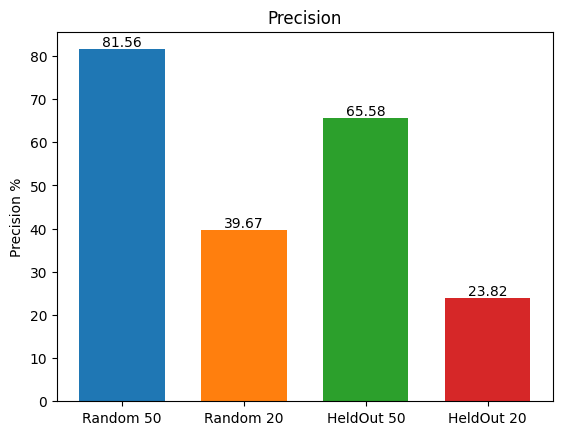

In [69]:
data_cat = ['Random 50', 'Random 20' ,'HeldOut 50', 'HeldOut 20']
y = [PreR50, PreR20, PreH50, PreH20]
y = [round(100 * x, 2) for x in y]
fig, ax = plt.subplots()
x = np.arange(len(data_cat))
width = 0.7  # the width of the bars
for i, j in enumerate(y):
    rects = ax.bar(x[i], j, width, label=data_cat[i])
    ax.bar_label(rects, padding=0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, data_cat)
ax.set_ylabel('Precision %')
ax.set_title('Precision')
plt.show()

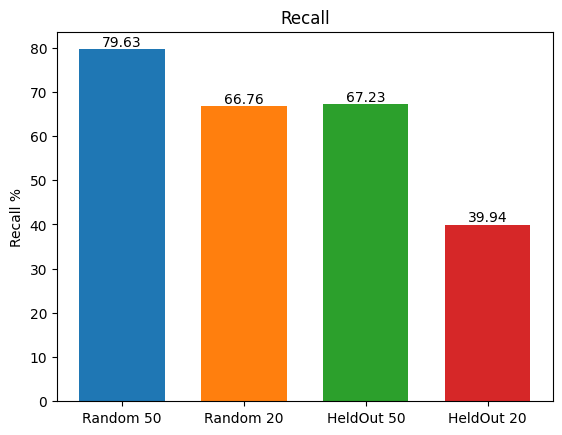

In [70]:
data_cat = ['Random 50', 'Random 20' ,'HeldOut 50', 'HeldOut 20']
y = [RecR50, RecR20, RecH50, RecH20]
y = [round(100 * x, 2) for x in y]
fig, ax = plt.subplots()
x = np.arange(len(data_cat))
width = 0.7  # the width of the bars
for i, j in enumerate(y):
    rects = ax.bar(x[i], j, width, label=data_cat[i])
    ax.bar_label(rects, padding=0)

# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_xticks(x, data_cat)
ax.set_ylabel('Recall %')
ax.set_title('Recall')
plt.show()